In [1]:
import source_synphot.passband
import source_synphot.io
import source_synphot.source
import astropy.table as at
from collections import OrderedDict
import pysynphot as S
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
%matplotlib notebook

#from zp_fit import *
from scipy.optimize import minimize
from astropy.stats import sigma_clip
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
def myround(x, prec=2, base=.5):
    return round(base * round(float(x)/base),prec)

In [4]:
models = at.Table.read('ckmodels.txt',format='ascii')
logZ = 0.
model_sed_names = []
temp = []
for s in models:
    teff = max(3500.,s['teff'])
    logg = myround(s['logg'])
    # the models with logg < 1 are just padded with 0s
    if logg >= 1:
        temp.append(teff)
        modstring = 'ckmod{:.0f}_{:.1f}_{:.2f}'.format(teff,logZ, logg)
        model_sed_names.append(modstring)
model_sed = source_synphot.source.load_source(model_sed_names)

In [5]:
passbands = at.Table.read('source_synphot/passbands/pbzptmag.txt',format='ascii')
pbnames = [x['obsmode'] for x in passbands if x['passband'].startswith("Kep")]
pbnames += [x['obsmode'] for x in passbands if x['passband'].startswith("PS1")]
model_mags = 0.
model = 'AB'
pbs = source_synphot.passband.load_pbs(pbnames, model_mags, model)
pbnames = pbs.keys()

In [6]:
color1 = 'ps1g_ps1r'
color2 = 'ps1r_ps1i'
col1 = []
col2 = []
col3 = []
col4 = []
col5 = []
# construct color-color vectors
for modelname in model_sed:
    model= model_sed[modelname]
    model = S.ArraySpectrum(model.wave, model.flux, name=modelname)
    c1, c2 = color1.split('_')
    pb1, zp1 = pbs[c1]
    pb2, zp2 = pbs[c2]
    c3, c4 = color2.split('_')
    c5 = 'Kep'
    pb3, zp3 = pbs[c3]
    pb4, zp4 = pbs[c4]
    pb5, zp5 = pbs[c5]
    thiscol1 = source_synphot.passband.syncolor(model, pb1, pb2, zp1, zp2)
    thiscol2 = source_synphot.passband.syncolor(model, pb3, pb4, zp3, zp4)
    thiscol3 = source_synphot.passband.syncolor(model, pb5, pb3, zp5, zp3)
    thiscol4 = source_synphot.passband.syncolor(model, pb5, pb4, zp5, zp4)
    thiscol5 = source_synphot.passband.syncolor(model, pb1, pb5, zp1, zp5)
    col1.append(thiscol1)
    col2.append(thiscol2)
    col3.append(thiscol3)
    col4.append(thiscol4)
    col5.append(thiscol5)
col1 = np.array(col1)
col2 = np.array(col2)
col3 = np.array(col3)
col4 = np.array(col4)
col5 = np.array(col5)
# select only useful objects
good = ~np.isnan(col1)* ~np.isnan(col2)* ~np.isnan(col3)* ~np.isnan(col4)* ~np.isnan(col5)
good = np.array(good)

In [7]:
data = pd.read_csv('../calibration/kepler/K2_all_PS1_psc_ev.csv')
data = data.iloc[(data['ps_score'].values > 0.9) & (data['PDC'].values > 0)]
#cind =  ((data['campaign'].values == 16) & (data['Channel'].values == 70))
gb = data['gMeanPSFMag'].values
gbe = data['gMeanPSFMagErr'].values
rb = data['rMeanPSFMag'].values
rbe = data['rMeanPSFMagErr'].values
ib = data['iMeanPSFMag'].values
ibe = data['iMeanPSFMagErr'].values
kb = -2.5*np.log10(data['PDC'].values)
kbe = 0.434 * np.abs(data['PDCe'].values) / np.abs(data['PDC'].values)

In [28]:

def Plotter(K,PS1_A,Colours,Compare,Channel, Close = True):
    Params = {}
    Params['kzp'] = K[0]
    Params['Ak'] = K[1]
    Params['Ag'] = PS1_A[0]
    Params['Ar'] = PS1_A[1]
    Params['Ai'] = PS1_A[2]
    plt.suptitle('Channel ' + str(Channel) + ', Zp = ' + str(np.round(K[0],3)) + 
                 '\n' + 'Ak ={}, Ag = {}, Ar = {}, Ai ={}'.format(np.round(K[1],3),
                                                                  np.round(PS1_A[0],3),
                                                                  np.round(PS1_A[1],3),
                                                                  np.round(PS1_A[2],3)))
    for i in range(len(Compare)):
        X,Y = Compare[i]
        keys = np.array(list(Colours.keys()))
        xind = 'mod ' + X == keys
        x = Colours[keys[xind][0]]
        yind = 'mod ' + Y == keys
        y = Colours[keys[yind][0]]

        x_interp = np.arange(np.nanmin(x),0.9,0.01)
        inter = interpolate.interp1d(x,y)
        l_interp = inter(x_interp)
        locus = np.array([x_interp,l_interp])
        # observed
        xind = 'obs ' + X == keys
        x = Colours[keys[xind][0]]
        yind = 'obs ' + Y == keys
        y = Colours[keys[yind][0]]
        #print(X,Y)
        c1,c2 = X.split('-')
        c3,c4 = Y.split('-')
        #print(c1,c2,c3,c4)

        # parameters
        ob_x = x.copy() 
        ob_x[0,:] += Params['A'+c1] - Params['A'+c2]
        if c1 == 'k': ob_x += Params['kzp']
        if c2 == 'k': ob_x -= Params['kzp']

        ob_y = y.copy() 
        ob_y[0,:] += Params['A'+c3] - Params['A'+c4]
        if c3 == 'k': ob_y[0,:] += Params['kzp']
        if c4 == 'k': ob_y[0,:] -= Params['kzp']

        ind = np.where((ob_x[0,:] <= 1) & (ob_x[0,:] > -0.5) & ((ob_y[1,:] < 5)))[0]
        ob_x = ob_x[:,ind]
        ob_y = ob_y[:,ind]
        
        plt.subplot(2,2,i+1)
        plt.xlabel(X)
        plt.ylabel(Y)
        plt.errorbar(ob_x[0,:],ob_y[0,:],ob_y[1,:],fmt='.',alpha=0.4)
        plt.plot(locus[0,:],locus[1,:])
        plt.xlim(-0.5, 1)
        plt.ylim(-.5, 1)
    plt.subplots_adjust(wspace=.25,hspace=.2)
    plt.savefig('./figs/Fit_channel_' + str(Channel) + '.png')
    if Close:
        plt.close()
    
def Dot_prod_error(x,y,Model):
    """
    Calculate the error projection in the direction of a selected point.
    """
    #print(Model.shape)
    adj = y[0,:] - Model[1,:]
    op = x[0,:] - Model[0,:]
    #print(adj.shape,op.shape)
    hyp = np.sqrt(adj**2 + op**2)
    costheta = adj / hyp
    yerr_proj = abs(y[1,:] * costheta)
    xerr_proj = abs(x[1,:] * costheta)
    
    proj_err = yerr_proj + xerr_proj
    #print(proj_err)
    return proj_err    
    
def Dist_tensor(X,Y,Params,Colours,Second=False,Plot = False):
    keys = np.array(list(Colours.keys()))
    xind = 'mod ' + X == keys
    x = Colours[keys[xind][0]]
    yind = 'mod ' + Y == keys
    y = Colours[keys[yind][0]]
    
    x_interp = np.arange(np.nanmin(x),0.9,0.01)
    inter = interpolate.interp1d(x,y)
    l_interp = inter(x_interp)
    locus = np.array([x_interp,l_interp])
    # observed
    xind = 'obs ' + X == keys
    x = Colours[keys[xind][0]]
    yind = 'obs ' + Y == keys
    y = Colours[keys[yind][0]]
    #print(X,Y)
    c1,c2 = X.split('-')
    c3,c4 = Y.split('-')
    #print(c1,c2,c3,c4)
    

    # parameters
    ob_x = x.copy() 
    ob_y = y.copy() 
    if X == 'g-r':
        indo = np.where((ob_x[0,:] <= .9) & (ob_x[0,:] >= 0.5))[0]
    elif X == 'r-i':
        indo = np.where((ob_x[0,:] <= .5) & (ob_x[0,:] >= 0.1))[0]
    
    ob_x[0,:] += Params['A'+c1] - Params['A'+c2]
    if c1 == 'k': ob_x += Params['kzp']
    if c2 == 'k': ob_x -= Params['kzp']

    
    ob_y[0,:] += Params['A'+c3] - Params['A'+c4]
    if c3 == 'k': ob_y[0,:] += Params['kzp']
    if c4 == 'k': ob_y[0,:] -= Params['kzp']
    
    if X == 'g-r':
        ind = np.where((ob_x[0,:] <= .9) & (ob_x[0,:] >= 0.5))[0]
    elif X == 'r-i':
        ind = np.where((ob_x[0,:] <= .5) & (ob_x[0,:] >= 0.1))[0]
    ob_x = ob_x[:,ind]
    ob_y = ob_y[:,ind]
    
    
    if Plot:
        plt.figure()
        plt.title(X + ' ' + Y)
        plt.plot(ob_x[0,:],ob_y[0,:],'.')
        plt.plot(locus[0,:],locus[1,:])
    #print(ob_x.shape)
    dist_tensor = []
    #print(Y + ' ', ob_y.shape[1])
    for i in range(ob_y.shape[1]):
        dist = np.sqrt((ob_x[0,i] - locus[0,:])**2 + (ob_y[0,i] - locus[1,:])**2) 
        dist_tensor += [dist/ ob_y[1,i]]
    
    dist_tensor = np.array(dist_tensor)
    #print(X + Y +' dist ',dist_tensor.shape)
    if len(dist_tensor) > 5:
        minind = np.nanargmin(abs(dist_tensor),axis=1)

        proj_err = Dot_prod_error(ob_x,ob_y,locus[:,minind])
        mindist = np.nanmin(abs(dist_tensor),axis=1)
        if Second:
            proj_err = proj_err[mindist < 1] 
            mindist = mindist[mindist < 1] 
            #ind = mindist < 6*(proj_err)
            #proj_err = proj_err[ind < 1] 
            #mindist = mindist[ind < 1] 
        if len(mindist) > 0:
            residual = np.nansum(mindist)# / proj_err)
        else:
            #print('infs')
            residual = np.inf
    else:
        residual = np.inf
        #residual += 100*np.sum(np.isnan(dist))
    #print(residual)
    cut_points = len(indo) - len(ind)
    return residual + cut_points * 100
    
def SLR_fit_multi(K,PS1_A,Colours,Compare,Second=False):
    
    params = {}
    params['kzp'] = K[0]
    params['Ak'] = K[1]
    params['Ag'] = PS1_A[0]
    params['Ar'] = PS1_A[1]
    params['Ai'] = PS1_A[2]
    res = 0
    #print(K)
    for x,y in Compare:
        res += Dist_tensor(x,y,params,Colours,Second)
    print('residual ', res)
    return res
    

In [13]:
ps1a = np.array([0.00040898, -0.01245065,  0.00042329])
cind =  ((data['campaign'].values == 16) & (data['Channel'].values == 1) & (kbe < 100))

colours = {}
colours['obs g-r'] = np.array([(gb - rb)[cind], (gbe + rbe)[cind]])
colours['obs k-i'] = np.array([(kb - ib)[cind], (kbe + ibe)[cind]])
colours['obs k-r'] = np.array([(kb - rb)[cind], (kbe + rbe)[cind]])
colours['obs r-i'] = np.array([(rb - ib)[cind], (rbe + ibe)[cind]])
colours['obs g-k'] = np.array([(gb - kb)[cind], (gbe + kbe)[cind]])
colours['mod g-r'] = col1[good]
colours['mod r-i'] = col2[good]
colours['mod k-r'] = col3[good]
colours['mod k-i'] = col4[good]
colours['mod g-k'] = col5[good]

In [29]:
compare = np.array([['g-r','k-r'],['g-r','k-i'],['r-i','g-k']])
#compare = np.array([['g-r','k-r'],['g-r','k-i'],['g-r','r-i'],['r-i','g-k']])
k0 = np.array([20,0])

bds = [(20,27),(-abs(ps1a[0]),abs(ps1a[0]))]
res = minimize(SLR_fit_multi,k0,args=(ps1a,colours,compare,False),bounds=bds)

residual  96937.72352775325
residual  96937.7233334565
residual  96937.7233334565
residual  26123.673906383294
residual  26123.674078774715
residual  26123.674078774693
residual  26717.920869585272
residual  26717.92069087305
residual  26717.92069087305
residual  1199.5554313290836
residual  1199.5555405852847
residual  1199.5555405852697
residual  48036.522400457514
residual  48036.52221210835
residual  48036.52221210835
residual  4043.3333781290203
residual  4043.333222540592
residual  4043.333222540592
residual  785.1417038249141
residual  785.1416831265115
residual  785.1416831265226
residual  783.8587987976846
residual  783.858821785692
residual  783.8588217856944
residual  779.4436235235265
residual  779.4436145606282
residual  779.4436145606282
residual  780.7973296653006
residual  780.7973466236253
residual  780.7973466236292
residual  778.9434175515532
residual  778.9434172045654
residual  778.9434172045601
residual  778.9428799199954
residual  778.9428800414375
residual  778.

<IPython.core.display.Javascript object>


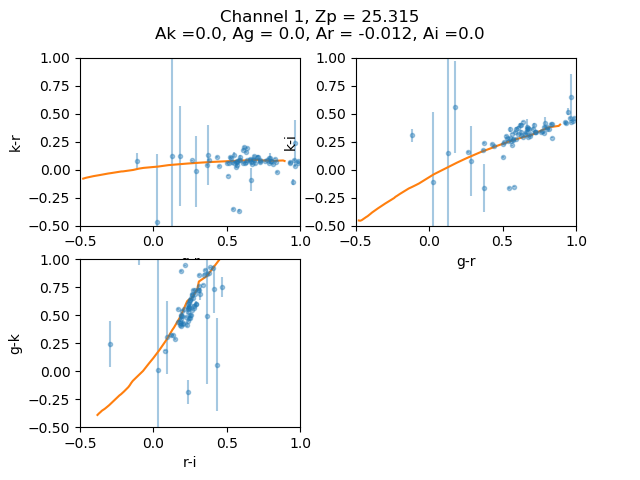

In [31]:
Plotter(res.x,ps1a,colours,compare,1,False)